# Bayesian Optimization with Calibrated Model

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# fix random seeds
rng_seed = 1
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../../../NN_prior/")
from custom_mean import CustomMean

## Definition of Objective

In [2]:
# define Xopt vocs
vocs_yaml = """
variables:
  distgen:r_dist:sigma_xy:value: [0.21021247820852546, 0.4999996083265339]
  distgen:t_dist:length:value: [3.000000758511308, 11.998569812014836]
  SOL1:solenoid_field_scale: [0.19409053333889578, 0.2563030896232562]
  CQ01:b1_gradient: [-0.009999618141995313, 0.0099925212795954]
  SQ01:b1_gradient: [-0.009999490058927914, 0.009999443099573097]
  L0A_phase:dtheta0_deg: [-24.998714513984325, 9.991752397382681]
  L0B_phase:dtheta0_deg: [-24.99972566363747, 9.998904767155892]
  QA01:b1_gradient: [1.000039854940649, 3.998197816908352]
  QA02:b1_gradient: [-3.990444304119449, -1.0105116218007806]
  QE01:b1_gradient: [1.0007061999094193, 6.9997773994714345]
  QE02:b1_gradient: [-6.999887318319171, 0.9983521010385275]
  QE03:b1_gradient: [-6.998418428856965, 0.9993010487139868]
  QE04:b1_gradient: [1.000026533968218, 6.998086093251312]
constraints: {}
objectives: {sigma_xy: MINIMIZE}
constants: {'distgen:total_charge:value': 250.0, 'L0A_scale:voltage': 58000000.0,
  'L0B_scale:voltage': 70000000.0}
observables: []
"""
vocs = VOCS.from_yaml(vocs_yaml)

In [3]:
# define LUME-model
model_directory = "../lcls_cu_injector_nn_model/model/"
input_sim_to_nn = torch.load(model_directory + "input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_directory + "output_sim_to_nn.pt")
with open(model_directory + "sim_variables.yml", "r") as f:
    input_variables, output_variables = variables_from_yaml(f)
    f.close()
lume_model = PyTorchModel(
    model_file=model_directory + "model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_sim_to_nn],
    output_transformers=[output_sim_to_nn],
)

In [4]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs,
)

In [5]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2) * 1e3  # in mm

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("sigma_x")
        idx_sigma_y = self.model.output_order.index("sigma_y")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [6]:
# Xopt evaluator function
def evaluate(input_dict):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["sigma_x"], model_result["sigma_y"])
    return {vocs.objective_names[0]: sigma_xy.detach().item()}

## Definition of Custom Mean

In [7]:
# load calibrated model
cal_model = PyTorchModel(
    model_file="calibrated_model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_sim_to_nn],
    output_transformers=[output_sim_to_nn],
)
cal_module = LUMEModule(
    model=cal_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs,
)

# define mean
custom_mean = ObjectiveModel(cal_module)
custom_mean

ObjectiveModel(
  (model): LUMEModule(
    (base_model): LinearCalibration(
      (model): Sequential(
        (0): Linear(in_features=16, out_features=100, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=100, out_features=200, bias=True)
        (3): ELU(alpha=1.0)
        (4): Dropout(p=0.05, inplace=False)
        (5): Linear(in_features=200, out_features=200, bias=True)
        (6): ELU(alpha=1.0)
        (7): Dropout(p=0.05, inplace=False)
        (8): Linear(in_features=200, out_features=300, bias=True)
        (9): ELU(alpha=1.0)
        (10): Dropout(p=0.05, inplace=False)
        (11): Linear(in_features=300, out_features=300, bias=True)
        (12): ELU(alpha=1.0)
        (13): Dropout(p=0.05, inplace=False)
        (14): Linear(in_features=300, out_features=200, bias=True)
        (15): ELU(alpha=1.0)
        (16): Dropout(p=0.05, inplace=False)
        (17): Linear(in_features=200, out_features=100, bias=True)
        (18): ELU(alpha=1.0)
        (19

## Xopt Initialization

In [8]:
# Xopt definition
model_constructor = StandardModelConstructor(
    mean_modules={vocs.objective_names[0]: custom_mean},
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

In [9]:
# create initial samples
n_init = 3
X.random_evaluate(n_samples=n_init)

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.379152,9.278009,0.244715,-0.000780,0.005911,-13.468219,5.085554,1.095197,-3.622092,6.765485,0.211751,-3.264805,2.880413,250.0,58000000.0,70000000.0,3.777476,0.001234,False
2,0.291259,10.677977,0.234805,0.001612,-0.007562,-4.609937,3.065624,3.058503,-3.676379,5.980953,-2.369768,-4.534138,1.991952,250.0,58000000.0,70000000.0,3.022104,0.000666,False
3,0.499966,11.167655,0.231619,-0.003706,0.009452,-9.557066,-18.026058,1.922505,-1.263938,1.731738,-6.663078,-1.524104,6.888392,250.0,58000000.0,70000000.0,3.062581,0.000491,False


## Bayesian Optimization

In [10]:
%%time
n_step = 50
for _ in range(n_step):
    X.step()

CPU times: user 10min 57s, sys: 52.2 s, total: 11min 50s
Wall time: 10min 20s


## Display Results

In [11]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.379152,9.278009,0.244715,-0.000780,0.005911,-13.468219,5.085554,1.095197,-3.622092,6.765485,0.211751,-3.264805,2.880413,250.0,58000000.0,70000000.0,3.777476,0.001234,False
2,0.291259,10.677977,0.234805,0.001612,-0.007562,-4.609937,3.065624,3.058503,-3.676379,5.980953,-2.369768,-4.534138,1.991952,250.0,58000000.0,70000000.0,3.022104,0.000666,False
3,0.499966,11.167655,0.231619,-0.003706,0.009452,-9.557066,-18.026058,1.922505,-1.263938,1.731738,-6.663078,-1.524104,6.888392,250.0,58000000.0,70000000.0,3.062581,0.000491,False
4,0.359258,11.813358,0.242642,-0.002422,0.006624,-11.572785,-10.406179,2.610622,-2.123989,2.687230,-1.104676,-2.337743,5.602575,250.0,58000000.0,70000000.0,1.697055,0.000745,False
5,0.216759,9.176337,0.238891,0.008835,-0.009546,7.339253,-13.896232,3.362921,-2.446193,6.816698,-1.924516,-3.216879,5.199471,250.0,58000000.0,70000000.0,3.687984,0.000716,False
6,0.429326,4.988499,0.244957,-0.007644,0.005514,-21.300388,5.974374,1.724248,-1.424424,3.714013,-4.033816,-5.393294,1.961079,250.0,58000000.0,70000000.0,1.060984,0.000662,False
7,0.305900,10.626565,0.243474,0.001281,-0.007038,0.143311,2.254512,3.424974,-3.246266,5.511460,-2.249319,-3.113781,2.158725,250.0,58000000.0,70000000.0,0.444480,0.000524,False
8,0.290770,11.971099,0.227165,-0.010000,-0.009999,2.030848,-10.524455,3.709005,-2.736486,1.247007,0.898995,-3.865645,6.090668,250.0,58000000.0,70000000.0,2.470596,0.000667,False
9,0.401027,10.033058,0.242018,-0.010000,-0.002082,0.871222,-23.192547,2.252151,-1.656264,4.470692,-0.177405,-3.722875,6.881888,250.0,58000000.0,70000000.0,2.965140,0.000714,False
10,0.374308,7.326603,0.243739,-0.009973,-0.009999,-21.489425,7.397724,2.905501,-3.014245,1.741062,-1.734083,-1.816053,1.838330,250.0,58000000.0,70000000.0,0.818248,0.000602,False


In [12]:
# predict optimum
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(X.evaluator.evaluate(x_optimum.to_dict("index")[0]), index=[0])
y_optimum

,sigma_xy,xopt_runtime,xopt_error
0,0.614472,0.000624,False


In [13]:
# calculate running minimum
running_min = []
for i in range(len(X.data)):
    running_min.append(X.data[vocs.objective_names[0]].iloc[:i+1].min())

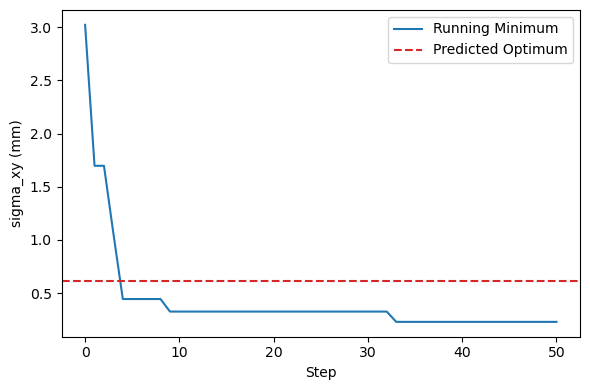

In [14]:
# plot performance
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(torch.arange(n_step + 1), running_min[n_init - 1:], "C0-", label="Running Minimum")
ax.axhline(y=y_optimum[vocs.objective_names[0]][0], color="C3", linestyle="--", label="Predicted Optimum")
ax.set_xlabel("Step")
ax.set_ylabel(f"{vocs.objective_names[0]} (mm)")
ax.legend()
fig.tight_layout()